In [ ]:
import os
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2
import torch.nn.functional as F

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224 
BATCH_SIZE = 32
EPOCHS = 35
LR = 1e-3

base_path = "/kaggle/input/csiro-biomass"
train_csv = os.path.join(base_path, "train.csv")
image_root = base_path

# ===========================
# 2. 資料前處理 (特徵工程)
# ===========================
print("正在處理資料與特徵工程...")
full_df = pd.read_csv(train_csv)

# A. 數值特徵補缺值 
full_df['Pre_GSHH_NDVI'] = full_df['Pre_GSHH_NDVI'].fillna(full_df['Pre_GSHH_NDVI'].mean())
full_df['Height_Ave_cm'] = full_df['Height_Ave_cm'].fillna(0)

# B. 時間特徵 (捕捉季節性)
full_df['Sampling_Date'] = pd.to_datetime(full_df['Sampling_Date'])
full_df['month_sin'] = np.sin(2 * np.pi * full_df['Sampling_Date'].dt.month / 12)
full_df['month_cos'] = np.cos(2 * np.pi * full_df['Sampling_Date'].dt.month / 12)

# C. 物理特徵 (模擬生物量體積)
full_df['bio_volume'] = full_df['Pre_GSHH_NDVI'] * full_df['Height_Ave_cm']

# D. 類別特徵編碼 (State, Species, Target_Name)
le_state = LabelEncoder()
full_df['state_code'] = le_state.fit_transform(full_df['State'].fillna('Unknown'))

le_species = LabelEncoder()
full_df['species_code'] = le_species.fit_transform(full_df['Species'].fillna('Unknown'))

le_target = LabelEncoder()
full_df['target_id'] = le_target.fit_transform(full_df['target_name'])

# E. Log Target (輔助用，我們主要用 Scaled Target)
if 'target' in full_df.columns:
    full_df['log_target'] = np.log1p(full_df['target'])

# F. 切分資料
train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42)

# G. 數值標準化
num_cols = ['month_sin', 'month_cos', 'Pre_GSHH_NDVI', 'Height_Ave_cm', 'bio_volume']
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
val_df[num_cols] = scaler.transform(val_df[num_cols])

# ★★★ H. 目標值標準化 (Target Scaling) ★★★
target_scaler = StandardScaler()
train_target_scaled = target_scaler.fit_transform(train_df[['target']].values)
val_target_scaled = target_scaler.transform(val_df[['target']].values)

train_df['target_scaled'] = train_target_scaled
val_df['target_scaled'] = val_target_scaled

# 重置 index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# 記錄類別數量
n_states = len(le_state.classes_)
n_species = len(le_species.classes_)
n_targets = len(le_target.classes_)

print(f"✅ 資料準備完成。使用 ResNet18 + {len(num_cols)} 個數值特徵 + 3 個類別特徵")

# ===========================
# 3. Dataset 定義
# ===========================
class ResNetFusionDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        
        # 轉 Tensor
        self.nums = torch.tensor(self.df[num_cols].values, dtype=torch.float32)
        self.cat_state = torch.tensor(self.df['state_code'].values, dtype=torch.long)
        self.cat_species = torch.tensor(self.df['species_code'].values, dtype=torch.long)
        self.cat_target_id = torch.tensor(self.df['target_id'].values, dtype=torch.long)
        
        self.targets_scaled = torch.tensor(self.df['target_scaled'].values, dtype=torch.float32)
        self.raw_targets = torch.tensor(self.df['target'].values, dtype=torch.float32) # 用於驗證
        self.img_paths = self.df['image_path'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.img_paths[idx])
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE))
            
        if self.transform:
            image = self.transform(image)
            
        return (image, self.nums[idx], self.cat_state[idx], self.cat_species[idx], 
                self.cat_target_id[idx], self.targets_scaled[idx], self.raw_targets[idx])

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), # 牧草適合垂直翻轉
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = ResNetFusionDataset(train_df, image_root, train_transform)
val_dataset = ResNetFusionDataset(val_df, image_root, val_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s] 
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


🚀 開始訓練 ResNet18 高分基線版...


Epoch 1: 100%|██████████| 45/45 [00:47<00:00,  1.05s/it]


Epoch 1 | Loss: 0.7626 | RMSE: 29.8689 | R²: -0.3251 ➡ NEW BEST!


Epoch 2: 100%|██████████| 45/45 [00:43<00:00,  1.04it/s]


Epoch 2 | Loss: 0.4681 | RMSE: 15.2465 | R²: 0.6547 ➡ NEW BEST!


Epoch 3: 100%|██████████| 45/45 [00:43<00:00,  1.04it/s]


Epoch 3 | Loss: 0.4807 | RMSE: 19.7188 | R²: 0.4225 


Epoch 4: 100%|██████████| 45/45 [00:43<00:00,  1.03it/s]


Epoch 4 | Loss: 0.4478 | RMSE: 16.1160 | R²: 0.6142 


Epoch 5: 100%|██████████| 45/45 [00:43<00:00,  1.04it/s]


Epoch 5 | Loss: 0.3747 | RMSE: 15.3345 | R²: 0.6507 


Epoch 6: 100%|██████████| 45/45 [00:43<00:00,  1.04it/s]


Epoch 6 | Loss: 0.3445 | RMSE: 13.4372 | R²: 0.7318 ➡ NEW BEST!


Epoch 7: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 7 | Loss: 0.3245 | RMSE: 13.2534 | R²: 0.7391 ➡ NEW BEST!


Epoch 8: 100%|██████████| 45/45 [00:43<00:00,  1.04it/s]


Epoch 8 | Loss: 0.3065 | RMSE: 13.8439 | R²: 0.7153 


Epoch 9: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


Epoch 9 | Loss: 0.3027 | RMSE: 25.1056 | R²: 0.0638 


Epoch 10: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


Epoch 10 | Loss: 0.2998 | RMSE: 14.3199 | R²: 0.6954 


Epoch 11: 100%|██████████| 45/45 [00:43<00:00,  1.04it/s]


Epoch 11 | Loss: 0.3281 | RMSE: 13.9056 | R²: 0.7128 


Epoch 12: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 12 | Loss: 0.3142 | RMSE: 14.7620 | R²: 0.6763 


Epoch 13: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


Epoch 13 | Loss: 0.2762 | RMSE: 12.6013 | R²: 0.7641 ➡ NEW BEST!


Epoch 14: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


Epoch 14 | Loss: 0.2706 | RMSE: 18.5053 | R²: 0.4914 


Epoch 15: 100%|██████████| 45/45 [00:43<00:00,  1.05it/s]


Epoch 15 | Loss: 0.2891 | RMSE: 12.6813 | R²: 0.7611 


Epoch 16: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 16 | Loss: 0.2627 | RMSE: 12.2931 | R²: 0.7755 ➡ NEW BEST!


Epoch 17: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


Epoch 17 | Loss: 0.2338 | RMSE: 12.9997 | R²: 0.7490 


Epoch 18: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 18 | Loss: 0.2267 | RMSE: 11.7709 | R²: 0.7942 ➡ NEW BEST!


Epoch 19: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


Epoch 19 | Loss: 0.2031 | RMSE: 12.3528 | R²: 0.7734 


Epoch 20: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


Epoch 20 | Loss: 0.2164 | RMSE: 16.8263 | R²: 0.5795 


Epoch 21: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


Epoch 21 | Loss: 0.2046 | RMSE: 10.9841 | R²: 0.8208 ➡ NEW BEST!


Epoch 22: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


Epoch 22 | Loss: 0.2047 | RMSE: 11.2068 | R²: 0.8135 


Epoch 23: 100%|██████████| 45/45 [00:43<00:00,  1.04it/s]


Epoch 23 | Loss: 0.1909 | RMSE: 11.4505 | R²: 0.8053 


Epoch 24: 100%|██████████| 45/45 [00:43<00:00,  1.04it/s]


Epoch 24 | Loss: 0.1976 | RMSE: 11.4131 | R²: 0.8065 


Epoch 25: 100%|██████████| 45/45 [00:43<00:00,  1.05it/s]


Epoch 25 | Loss: 0.1833 | RMSE: 10.9975 | R²: 0.8204 


Epoch 26: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


Epoch 26 | Loss: 0.2116 | RMSE: 11.8091 | R²: 0.7929 


Epoch 27: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


Epoch 27 | Loss: 0.1934 | RMSE: 10.7728 | R²: 0.8276 ➡ NEW BEST!


Epoch 28: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


Epoch 28 | Loss: 0.1933 | RMSE: 10.6596 | R²: 0.8312 ➡ NEW BEST!


Epoch 29: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 29 | Loss: 0.1924 | RMSE: 10.5500 | R²: 0.8347 ➡ NEW BEST!


Epoch 30: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


Epoch 30 | Loss: 0.1713 | RMSE: 10.4421 | R²: 0.8380 ➡ NEW BEST!


Epoch 31: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


Epoch 31 | Loss: 0.1751 | RMSE: 10.0959 | R²: 0.8486 ➡ NEW BEST!


Epoch 32: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


Epoch 32 | Loss: 0.1579 | RMSE: 10.3241 | R²: 0.8417 


Epoch 33: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


Epoch 33 | Loss: 0.1632 | RMSE: 10.4830 | R²: 0.8368 


Epoch 34: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 34 | Loss: 0.1476 | RMSE: 10.3983 | R²: 0.8394 


Epoch 35: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 35 | Loss: 0.1576 | RMSE: 11.1497 | R²: 0.8154 


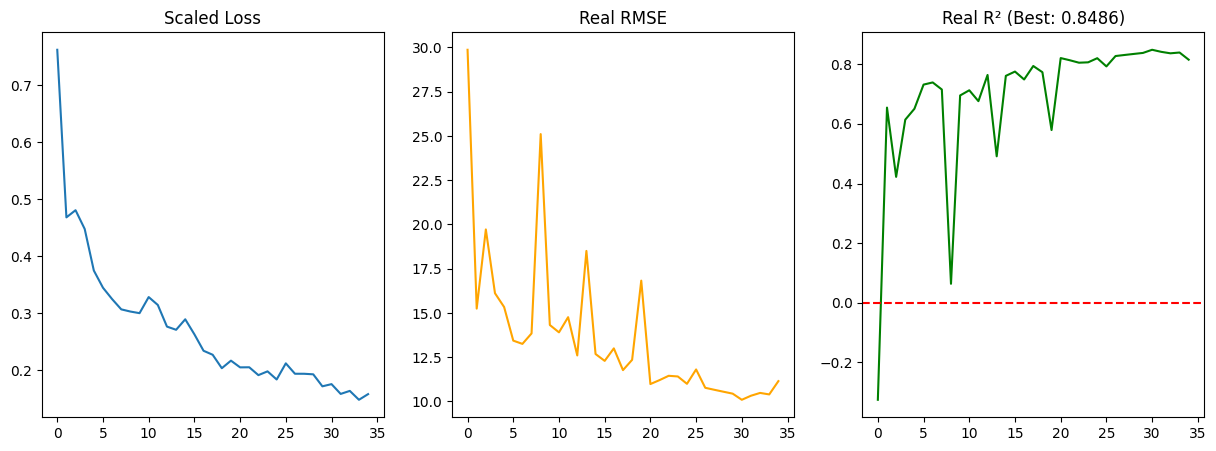


=== ResNet18 Grad-CAM ===


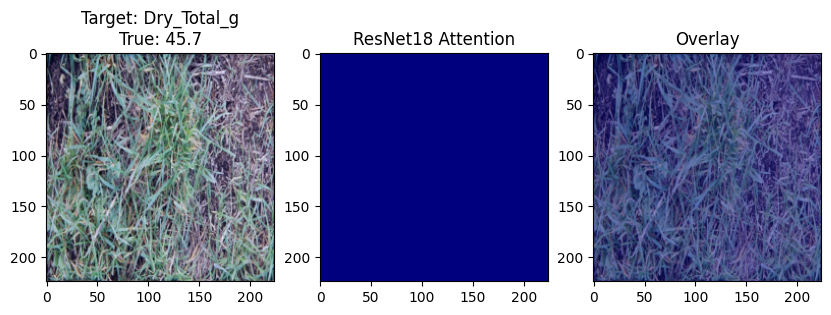

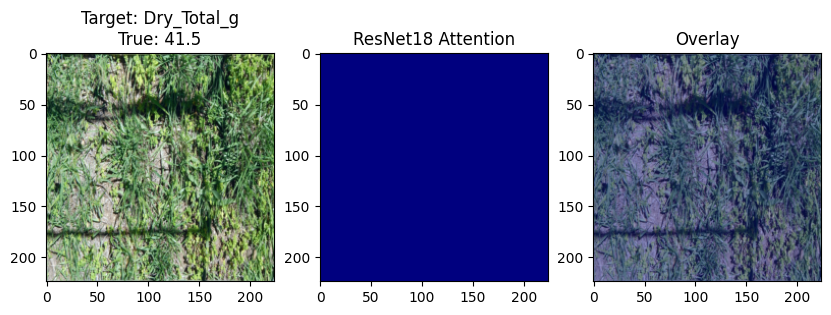

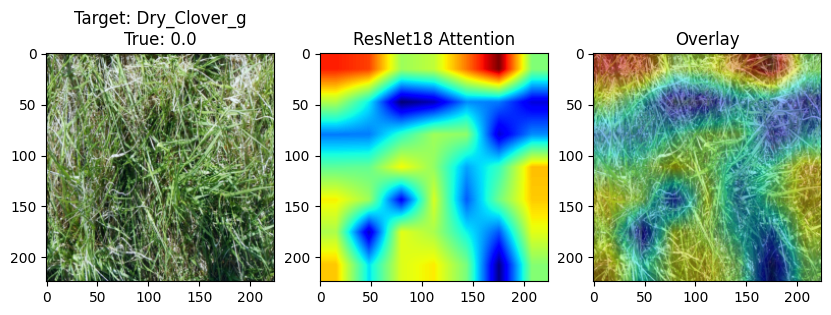

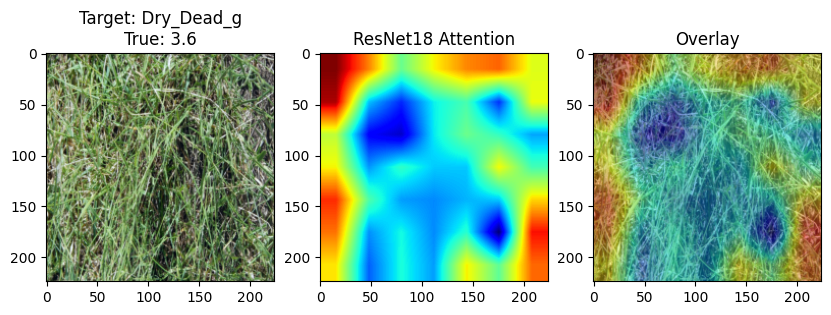

In [ ]:
# =============================
# ResNet18 高分基線模型 (Multimodal + Target Scaling)
# ===========================
# 4. 模型定義 (ResNet18 Fusion)
# ===========================
class ResNet18_Fusion(nn.Module):
    def __init__(self, n_nums, n_states, n_species, n_targets):
        super().__init__()
        
        # A. 影像分支
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.cnn_fc_in = self.cnn.fc.in_features # 512
        self.cnn.fc = nn.Identity() 
        
        # B. 類別分支 (Embedding)
        self.emb_state = nn.Embedding(n_states, 4)
        self.emb_species = nn.Embedding(n_species, 4)
        self.emb_target = nn.Embedding(n_targets, 8) 
        
        # C. 數值分支 (MLP)
        self.mlp_num = nn.Sequential(
            nn.Linear(n_nums, 32),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        
        # D. 融合層
        # 輸入: 512(Img) + 32(Num) + 4(State) + 4(Species) + 8(Target)
        fusion_dim = 512 + 32 + 4 + 4 + 8
        self.head = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1) # 輸出 Z-Score
        )
        
        # Hook for Grad-CAM
        self.gradients = None
        self.activations = None

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, img, nums, state, species, target_id):
        # 1. 影像特徵 (保留 Hook 點位)
        x = self.cnn.conv1(img)
        x = self.cnn.bn1(x)
        x = self.cnn.relu(x)
        x = self.cnn.maxpool(x)
        x = self.cnn.layer1(x)
        x = self.cnn.layer2(x)
        x = self.cnn.layer3(x)
        x = self.cnn.layer4(x) # Layer 4 是 ResNet18 最後的卷積層
        
        if x.requires_grad:
            h = x.register_hook(self.activations_hook)
        self.activations = x
        
        x_cnn = F.adaptive_avg_pool2d(x, (1, 1))
        x_cnn = torch.flatten(x_cnn, 1)
        
        # 2. 其他特徵
        x_num = self.mlp_num(nums)
        x_state = self.emb_state(state)
        x_species = self.emb_species(species)
        x_target = self.emb_target(target_id)
        
        # 3. 融合
        combined = torch.cat([x_cnn, x_num, x_state, x_species, x_target], dim=1)
        out = self.head(combined)
        return out
    
    def get_cam(self):
        gradients = self.gradients.cpu().data.numpy()
        activations = self.activations.cpu().data.numpy()
        weights = np.mean(gradients, axis=(2, 3))[0, :]
        cam = np.zeros(activations.shape[2:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[0, i, :, :]
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-8)
        return cam

# ===========================
# 5. 訓練流程
# ===========================
model = ResNet18_Fusion(len(num_cols), n_states, n_species, n_targets).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_losses, val_rmses, val_r2s = [], [], []
best_r2 = -float('inf')

print(f"🚀 開始訓練 ResNet18 高分基線版...")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    
    for imgs, nums, states, species, t_ids, targets_scaled, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs, nums, states, species, t_ids, targets_scaled = imgs.to(device), nums.to(device), states.to(device), species.to(device), t_ids.to(device), targets_scaled.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        preds = model(imgs, nums, states, species, t_ids)
        loss = criterion(preds, targets_scaled)
        
        # 梯度裁剪 (防止爆炸)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    
    # 驗證
    model.eval()
    all_preds_real = []
    all_targets_real = []
    
    with torch.no_grad():
        for imgs, nums, states, species, t_ids, _, raw_targets in val_loader:
            imgs, nums, states, species, t_ids = imgs.to(device), nums.to(device), states.to(device), species.to(device), t_ids.to(device)
            
            # 預測 Z-Score
            preds_scaled = model(imgs, nums, states, species, t_ids)
            preds_scaled_np = preds_scaled.cpu().numpy()
            
            # 反標準化 (還原成真實數值)
            preds_real = target_scaler.inverse_transform(preds_scaled_np)
            
            all_preds_real.append(preds_real)
            all_targets_real.append(raw_targets.numpy())
            
    all_preds = np.concatenate(all_preds_real).flatten()
    all_targets = np.concatenate(all_targets_real).flatten()
    # 限制最小值為 0
    all_preds = np.clip(all_preds, 0, None)
    
    # 計算真實指標
    mse = np.mean((all_targets - all_preds)**2)
    rmse = np.sqrt(mse)
    ss_res = np.sum((all_targets - all_preds)**2)
    ss_tot = np.sum((all_targets - np.mean(all_targets))**2)
    r2 = 1 - ss_res / (ss_tot + 1e-8)
    
    train_losses.append(train_loss)
    val_rmses.append(rmse)
    val_r2s.append(r2)
    
    if r2 > best_r2:
        best_r2 = r2
        torch.save(model.state_dict(), "/kaggle/working/best_resnet18_baseline.pth")
        msg = "➡ NEW BEST!"
    else:
        msg = ""
        
    print(f"Epoch {epoch+1} | Loss: {train_loss:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f} {msg}")
    scheduler.step(train_loss)

# ===========================
# 6. 可視化 (趨勢 + Grad-CAM)
# ===========================
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plt.plot(train_losses); plt.title('Scaled Loss')
plt.subplot(1,3,2); plt.plot(val_rmses, color='orange'); plt.title('Real RMSE')
plt.subplot(1,3,3); plt.plot(val_r2s, color='green'); plt.title(f'Real R² (Best: {best_r2:.4f})'); plt.axhline(0, c='r', ls='--')
plt.show()

# Grad-CAM 疊圖
print("\n=== ResNet18 Grad-CAM ===")
model.load_state_dict(torch.load("/kaggle/working/best_resnet18_baseline.pth"))
model.eval()

temp_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)
imgs, nums, states, species, t_ids, _, raw_targets = next(iter(temp_loader))
imgs, nums, states, species, t_ids = imgs.to(device), nums.to(device), states.to(device), species.to(device), t_ids.to(device)
target_map = {v: k for k, v in dict(zip(le_target.classes_, le_target.transform(le_target.classes_))).items()}

for i in range(4):
    img_tensor = imgs[i].unsqueeze(0).requires_grad_(True)
    num_tensor = nums[i].unsqueeze(0)
    state_tensor = states[i].unsqueeze(0)
    spec_tensor = species[i].unsqueeze(0)
    tid_tensor = t_ids[i].unsqueeze(0)
    
    model.zero_grad()
    out = model(img_tensor, num_tensor, state_tensor, spec_tensor, tid_tensor)
    out.backward()
    cam = model.get_cam()
    
    # 強化 CAM 對比度 
    if cam.max() > 0:
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    
    img_np = img_tensor.detach().cpu().squeeze().permute(1,2,0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]
    overlay = 0.6 * img_np + 0.4 * heatmap
    
    t_name = target_map[tid_tensor.item()]
    
    plt.figure(figsize=(10, 3))
    plt.subplot(1,3,1); plt.imshow(img_np); plt.title(f"Target: {t_name}\nTrue: {raw_targets[i].item():.1f}")
    plt.subplot(1,3,2); plt.imshow(cam, cmap='jet'); plt.title("ResNet18 Attention")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay")
    plt.show()

In [ ]:
# ==========================================
# 模型 2: SMA_Fusion 
# ==========================================
class SMA_Fusion(nn.Module):
    def __init__(self, n_nums, n_states, n_species, n_targets):
        super().__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(backbone.children())[:-2]) 
        self.attention_conv = nn.Sequential(nn.Conv2d(512, 1, 1), nn.Sigmoid())
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        self.emb_state = nn.Embedding(n_states, 4)
        self.emb_species = nn.Embedding(n_species, 4)
        self.emb_target = nn.Embedding(n_targets, 8)
        self.mlp_num = nn.Sequential(nn.Linear(n_nums, 32), nn.BatchNorm1d(32), nn.ReLU())
        
        fusion_dim = 512 + 32 + 4 + 4 + 8
        self.head = nn.Sequential(
            nn.Linear(fusion_dim, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 1)
        )
    def forward(self, img, nums, state, species, target_id):
        x = self.features(img)
        att = self.attention_conv(x)
        x = self.gap(x * att).flatten(1)
        x_num = self.mlp_num(nums)
        x_state = self.emb_state(state)
        x_species = self.emb_species(species)
        x_target = self.emb_target(target_id)
        combined = torch.cat([x, x_num, x_state, x_species, x_target], dim=1)
        return self.head(combined), att

model_sma = SMA_Fusion(len(num_cols), n_states, n_species, n_targets).to(device)
optimizer = optim.AdamW(model_sma.parameters(), lr=LR, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
criterion = nn.MSELoss()
scaler = torch.amp.GradScaler('cuda') 

best_r2_sma = -float('inf')
history_sma = {'val_rmse': [], 'val_r2': []}

print("🚀 開始訓練 SMA_Fusion (Fix Unpack Error)...")
for epoch in range(EPOCHS):
    model_sma.train()
    train_loss = 0
    
    for imgs, nums, states, species, t_ids, targets_scaled, _, mask in tqdm(train_loader, desc=f"[SMA] Epoch {epoch+1}"):
        imgs, nums, states, species, t_ids = imgs.to(device), nums.to(device), states.to(device), species.to(device), t_ids.to(device)
        targets_scaled = targets_scaled.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            preds, _ = model_sma(imgs, nums, states, species, t_ids)
            loss = criterion(preds, targets_scaled)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
    
    # 驗證
    model_sma.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for imgs, nums, states, species, t_ids, _, raw_targets, _ in val_loader:
            imgs, nums, states, species, t_ids = imgs.to(device), nums.to(device), states.to(device), species.to(device), t_ids.to(device)
            preds, _ = model_sma(imgs, nums, states, species, t_ids)
            preds_real = target_scaler.inverse_transform(preds.cpu().numpy())
            all_preds.append(preds_real)
            all_targets.append(raw_targets.numpy())
            
    all_preds = np.clip(np.concatenate(all_preds).flatten(), 0, None)
    all_targets = np.concatenate(all_targets).flatten()
    r2 = 1 - np.sum((all_targets - all_preds)**2) / (np.sum((all_targets - np.mean(all_targets))**2) + 1e-8)
    rmse = np.sqrt(np.mean((all_targets - all_preds)**2))
    
    history_sma['val_rmse'].append(rmse)
    history_sma['val_r2'].append(r2)
    
    if r2 > best_r2_sma:
        best_r2_sma = r2
        torch.save(model_sma.state_dict(), "/kaggle/working/best_SMA.pth")
        
    print(f"[SMA] Epoch {epoch+1} | Loss: {train_loss/len(train_loader):.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")
    scheduler.step(train_loss)
    
trained_models['SMA'] = model_sma
results_history['SMA'] = history_sma

🚀 開始訓練 SMA_Fusion (Fix Unpack Error)...


[SMA] Epoch 1: 100%|██████████| 45/45 [00:54<00:00,  1.20s/it]


[SMA] Epoch 1 | Loss: 0.6589 | RMSE: 15.9722 | R²: 0.6211


[SMA] Epoch 2: 100%|██████████| 45/45 [00:53<00:00,  1.20s/it]


[SMA] Epoch 2 | Loss: 0.3458 | RMSE: 14.3964 | R²: 0.6922


[SMA] Epoch 3: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 3 | Loss: 0.3267 | RMSE: 13.4253 | R²: 0.7323


[SMA] Epoch 4: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 4 | Loss: 0.2673 | RMSE: 12.2680 | R²: 0.7765


[SMA] Epoch 5: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 5 | Loss: 0.2870 | RMSE: 11.9348 | R²: 0.7884


[SMA] Epoch 6: 100%|██████████| 45/45 [00:54<00:00,  1.20s/it]


[SMA] Epoch 6 | Loss: 0.2547 | RMSE: 12.0604 | R²: 0.7840


[SMA] Epoch 7: 100%|██████████| 45/45 [00:53<00:00,  1.20s/it]


[SMA] Epoch 7 | Loss: 0.2551 | RMSE: 11.6922 | R²: 0.7970


[SMA] Epoch 8: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 8 | Loss: 0.2247 | RMSE: 10.8128 | R²: 0.8263


[SMA] Epoch 9: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 9 | Loss: 0.2067 | RMSE: 10.7958 | R²: 0.8269


[SMA] Epoch 10: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 10 | Loss: 0.2029 | RMSE: 11.2286 | R²: 0.8127


[SMA] Epoch 11: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 11 | Loss: 0.2411 | RMSE: 11.1683 | R²: 0.8147


[SMA] Epoch 12: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 12 | Loss: 0.1926 | RMSE: 10.9282 | R²: 0.8226


[SMA] Epoch 13: 100%|██████████| 45/45 [00:54<00:00,  1.20s/it]


[SMA] Epoch 13 | Loss: 0.1902 | RMSE: 10.1489 | R²: 0.8470


[SMA] Epoch 14: 100%|██████████| 45/45 [00:54<00:00,  1.20s/it]


[SMA] Epoch 14 | Loss: 0.1722 | RMSE: 10.9482 | R²: 0.8220


[SMA] Epoch 15: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 15 | Loss: 0.1732 | RMSE: 10.0799 | R²: 0.8491


[SMA] Epoch 16: 100%|██████████| 45/45 [00:53<00:00,  1.20s/it]


[SMA] Epoch 16 | Loss: 0.1764 | RMSE: 10.3609 | R²: 0.8406


[SMA] Epoch 17: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 17 | Loss: 0.1751 | RMSE: 10.6703 | R²: 0.8309


[SMA] Epoch 18: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 18 | Loss: 0.1755 | RMSE: 10.1694 | R²: 0.8464


[SMA] Epoch 19: 100%|██████████| 45/45 [00:54<00:00,  1.20s/it]


[SMA] Epoch 19 | Loss: 0.1490 | RMSE: 9.8234 | R²: 0.8567


[SMA] Epoch 20: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 20 | Loss: 0.1379 | RMSE: 9.5680 | R²: 0.8640


[SMA] Epoch 21: 100%|██████████| 45/45 [00:53<00:00,  1.20s/it]


[SMA] Epoch 21 | Loss: 0.1550 | RMSE: 9.6062 | R²: 0.8629


[SMA] Epoch 22: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 22 | Loss: 0.1352 | RMSE: 9.3459 | R²: 0.8703


[SMA] Epoch 23: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 23 | Loss: 0.1498 | RMSE: 9.1200 | R²: 0.8765


[SMA] Epoch 24: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 24 | Loss: 0.1309 | RMSE: 10.0424 | R²: 0.8502


[SMA] Epoch 25: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 25 | Loss: 0.1323 | RMSE: 9.5573 | R²: 0.8643


[SMA] Epoch 26: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 26 | Loss: 0.1263 | RMSE: 9.4867 | R²: 0.8663


[SMA] Epoch 27: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 27 | Loss: 0.1355 | RMSE: 9.4427 | R²: 0.8676


[SMA] Epoch 28: 100%|██████████| 45/45 [00:53<00:00,  1.20s/it]


[SMA] Epoch 28 | Loss: 0.1240 | RMSE: 9.1624 | R²: 0.8753


[SMA] Epoch 29: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 29 | Loss: 0.1297 | RMSE: 9.2466 | R²: 0.8730


[SMA] Epoch 30: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 30 | Loss: 0.1088 | RMSE: 9.6238 | R²: 0.8624


[SMA] Epoch 31: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 31 | Loss: 0.1259 | RMSE: 9.3138 | R²: 0.8712


[SMA] Epoch 32: 100%|██████████| 45/45 [00:53<00:00,  1.20s/it]


[SMA] Epoch 32 | Loss: 0.1159 | RMSE: 8.9648 | R²: 0.8806


[SMA] Epoch 33: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 33 | Loss: 0.1080 | RMSE: 9.2290 | R²: 0.8735


[SMA] Epoch 34: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[SMA] Epoch 34 | Loss: 0.1016 | RMSE: 9.2245 | R²: 0.8736


[SMA] Epoch 35: 100%|██████████| 45/45 [00:53<00:00,  1.20s/it]


[SMA] Epoch 35 | Loss: 0.1230 | RMSE: 9.4010 | R²: 0.8687


NameError: name 'trained_models' is not defined

In [9]:
# 1. 檢查並補建字典
if 'trained_models' not in globals():
    trained_models = {}
    print("已建立 trained_models 字典")

if 'results_history' not in globals():
    results_history = {}
    print("已建立 results_history 字典")

# 2. 嘗試儲存剛剛練好的 SMA 模型
try:
    if 'model_sma' in globals():
        trained_models['SMA'] = model_sma
        print("✅ 成功儲存 SMA 模型權重！")
    else:
        print("❌ 找不到 model_sma 變數，可能需要重新訓練。")

    if 'history_sma' in globals():
        results_history['SMA'] = history_sma
        print("✅ 成功儲存 SMA 訓練歷史！")
    else:
        print("⚠️ 找不到 history_sma，歷史數據可能已遺失。")
        
except Exception as e:
    print(f"儲存過程發生錯誤: {e}")

# 3. 顯示目前已有的模型
print(f"目前已儲存的模型: {list(trained_models.keys())}")

已建立 trained_models 字典
已建立 results_history 字典
✅ 成功儲存 SMA 模型權重！
✅ 成功儲存 SMA 訓練歷史！
目前已儲存的模型: ['SMA']


In [ ]:
# ==========================================
# 模型 3: MTL_Fusion 
# ==========================================
class MTL_Fusion(nn.Module):
    def __init__(self, n_nums, n_states, n_species, n_targets):
        super().__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(backbone.children())[:-2])
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=8, mode='bilinear'),
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid()
        )
        
        self.emb_state = nn.Embedding(n_states, 4)
        self.emb_species = nn.Embedding(n_species, 4)
        self.emb_target = nn.Embedding(n_targets, 8)
        self.mlp_num = nn.Sequential(nn.Linear(n_nums, 32), nn.BatchNorm1d(32), nn.ReLU())
        
        fusion_dim = 512 + 32 + 4 + 4 + 8
        self.head = nn.Sequential(
            nn.Linear(fusion_dim, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 1)
        )

    def forward(self, img, nums, state, species, target_id):
        x = self.features(img)
        
        # Task 1: Regression (主任務)
        x_cnn = self.gap(x).flatten(1)
        x_num = self.mlp_num(nums)
        x_state = self.emb_state(state)
        x_species = self.emb_species(species)
        x_target = self.emb_target(target_id)
        
        combined = torch.cat([x_cnn, x_num, x_state, x_species, x_target], dim=1)
        pred_reg = self.head(combined)
        
        # Task 2: Segmentation (輔助任務)
        pred_mask = self.decoder(x)
        
        return pred_reg, pred_mask

# MTL 訓練 (Multi-loss)
model_mtl = MTL_Fusion(len(num_cols), n_states, n_species, n_targets).to(device)
optimizer = optim.AdamW(model_mtl.parameters(), lr=LR, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
crit_reg = nn.MSELoss()
crit_seg = nn.BCELoss() 

best_r2_mtl = -float('inf')
history_mtl = {'val_rmse': [], 'val_r2': []}

print("🚀 開始訓練 MTL_Fusion...")
for epoch in range(EPOCHS):
    model_mtl.train()
    train_loss = 0
    for imgs, nums, states, species, t_ids, targets_scaled, _, mask_gt in tqdm(train_loader, desc=f"[MTL] Epoch {epoch+1}"):
        imgs, nums, states, species, t_ids = imgs.to(device), nums.to(device), states.to(device), species.to(device), t_ids.to(device)
        targets_scaled, mask_gt = targets_scaled.to(device).unsqueeze(1), mask_gt.to(device)
        
        optimizer.zero_grad()
        pred_reg, pred_mask = model_mtl(imgs, nums, states, species, t_ids)
        
        loss1 = crit_reg(pred_reg, targets_scaled)
        loss2 = crit_seg(pred_mask, mask_gt)
        loss = loss1 + 0.2 * loss2 # 0.2 是輔助任務權重
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    # 驗證 (只看回歸分數)
    model_mtl.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for imgs, nums, states, species, t_ids, _, raw_targets, _ in val_loader:
            imgs, nums, states, species, t_ids = imgs.to(device), nums.to(device), states.to(device), species.to(device), t_ids.to(device)
            pred_reg, _ = model_mtl(imgs, nums, states, species, t_ids)
            preds_real = target_scaler.inverse_transform(pred_reg.cpu().numpy())
            all_preds.append(preds_real)
            all_targets.append(raw_targets.numpy())
            
    all_preds = np.clip(np.concatenate(all_preds).flatten(), 0, None)
    all_targets = np.concatenate(all_targets).flatten()
    r2 = 1 - np.sum((all_targets - all_preds)**2) / (np.sum((all_targets - np.mean(all_targets))**2) + 1e-8)
    rmse = np.sqrt(np.mean((all_targets - all_preds)**2))
    
    history_mtl['val_rmse'].append(rmse)
    history_mtl['val_r2'].append(r2)
    
    if r2 > best_r2_mtl:
        best_r2_mtl = r2
        torch.save(model_mtl.state_dict(), "best_MTL.pth")
        
    print(f"[MTL] Epoch {epoch+1} | Loss: {train_loss/len(train_loader):.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")
    scheduler.step(train_loss)

np.save("history_MTL.npy", history_mtl)

🚀 開始訓練 MTL_Fusion...


[MTL] Epoch 1: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[MTL] Epoch 1 | Loss: 0.8332 | RMSE: 16.8934 | R²: 0.5761


[MTL] Epoch 2: 100%|██████████| 45/45 [00:55<00:00,  1.22s/it]


[MTL] Epoch 2 | Loss: 0.5627 | RMSE: 15.0519 | R²: 0.6635


[MTL] Epoch 3: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[MTL] Epoch 3 | Loss: 0.4899 | RMSE: 14.4547 | R²: 0.6897


[MTL] Epoch 4: 100%|██████████| 45/45 [00:55<00:00,  1.22s/it]


[MTL] Epoch 4 | Loss: 0.4521 | RMSE: 14.1497 | R²: 0.7026


[MTL] Epoch 5: 100%|██████████| 45/45 [00:55<00:00,  1.22s/it]


[MTL] Epoch 5 | Loss: 0.4231 | RMSE: 13.8383 | R²: 0.7156


[MTL] Epoch 6: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


[MTL] Epoch 6 | Loss: 0.4142 | RMSE: 55.2731 | R²: -3.5377


[MTL] Epoch 7: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[MTL] Epoch 7 | Loss: 0.4560 | RMSE: 16.5759 | R²: 0.5919


[MTL] Epoch 8: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[MTL] Epoch 8 | Loss: 0.4229 | RMSE: 12.7889 | R²: 0.7571


[MTL] Epoch 9: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[MTL] Epoch 9 | Loss: 0.3733 | RMSE: 12.6768 | R²: 0.7613


[MTL] Epoch 10: 100%|██████████| 45/45 [00:55<00:00,  1.22s/it]


[MTL] Epoch 10 | Loss: 0.3546 | RMSE: 12.4570 | R²: 0.7695


[MTL] Epoch 11: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[MTL] Epoch 11 | Loss: 0.3873 | RMSE: 12.9050 | R²: 0.7526


[MTL] Epoch 12: 100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


[MTL] Epoch 12 | Loss: 0.3570 | RMSE: 12.4609 | R²: 0.7694


[MTL] Epoch 13: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[MTL] Epoch 13 | Loss: 0.3311 | RMSE: 11.8996 | R²: 0.7897


[MTL] Epoch 14: 100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


[MTL] Epoch 14 | Loss: 0.3338 | RMSE: 12.0857 | R²: 0.7831


[MTL] Epoch 15: 100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


[MTL] Epoch 15 | Loss: 0.3101 | RMSE: 11.5493 | R²: 0.8019


[MTL] Epoch 16: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[MTL] Epoch 16 | Loss: 0.3216 | RMSE: 11.3080 | R²: 0.8101


[MTL] Epoch 17: 100%|██████████| 45/45 [00:53<00:00,  1.20s/it]


[MTL] Epoch 17 | Loss: 0.3113 | RMSE: 18.2882 | R²: 0.5032


[MTL] Epoch 18: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[MTL] Epoch 18 | Loss: 0.3113 | RMSE: 11.1050 | R²: 0.8168


[MTL] Epoch 19: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[MTL] Epoch 19 | Loss: 0.3507 | RMSE: 10.9988 | R²: 0.8203


[MTL] Epoch 20: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[MTL] Epoch 20 | Loss: 0.2751 | RMSE: 10.7424 | R²: 0.8286


[MTL] Epoch 21: 100%|██████████| 45/45 [00:55<00:00,  1.22s/it]


[MTL] Epoch 21 | Loss: 0.2954 | RMSE: 10.7305 | R²: 0.8290


[MTL] Epoch 22: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[MTL] Epoch 22 | Loss: 0.2663 | RMSE: 10.7935 | R²: 0.8270


[MTL] Epoch 23: 100%|██████████| 45/45 [00:54<00:00,  1.20s/it]


[MTL] Epoch 23 | Loss: 0.2762 | RMSE: 10.7715 | R²: 0.8277


[MTL] Epoch 24: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[MTL] Epoch 24 | Loss: 0.2756 | RMSE: 10.5583 | R²: 0.8344


[MTL] Epoch 25: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[MTL] Epoch 25 | Loss: 0.2678 | RMSE: 10.3636 | R²: 0.8405


[MTL] Epoch 26: 100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


[MTL] Epoch 26 | Loss: 0.2532 | RMSE: 10.3901 | R²: 0.8397


[MTL] Epoch 27: 100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


[MTL] Epoch 27 | Loss: 0.2444 | RMSE: 10.5663 | R²: 0.8342


[MTL] Epoch 28: 100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


[MTL] Epoch 28 | Loss: 0.2330 | RMSE: 10.7372 | R²: 0.8288


[MTL] Epoch 29: 100%|██████████| 45/45 [00:55<00:00,  1.22s/it]


[MTL] Epoch 29 | Loss: 0.2404 | RMSE: 10.3173 | R²: 0.8419


[MTL] Epoch 30: 100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


[MTL] Epoch 30 | Loss: 0.2477 | RMSE: 10.1574 | R²: 0.8468


[MTL] Epoch 31: 100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


[MTL] Epoch 31 | Loss: 0.2418 | RMSE: 10.1504 | R²: 0.8470


[MTL] Epoch 32: 100%|██████████| 45/45 [00:55<00:00,  1.24s/it]


[MTL] Epoch 32 | Loss: 0.2320 | RMSE: 10.0785 | R²: 0.8491


[MTL] Epoch 33: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[MTL] Epoch 33 | Loss: 0.2211 | RMSE: 9.9751 | R²: 0.8522


[MTL] Epoch 34: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[MTL] Epoch 34 | Loss: 0.2224 | RMSE: 9.8344 | R²: 0.8563


[MTL] Epoch 35: 100%|██████████| 45/45 [00:55<00:00,  1.24s/it]


[MTL] Epoch 35 | Loss: 0.2276 | RMSE: 9.9514 | R²: 0.8529


In [ ]:
# ==========================================
# 模型 4: PastureMask_Fusion 
# ==========================================
class PastureMask_Fusion(nn.Module):
    def __init__(self, n_nums, n_states, n_species, n_targets):
        super().__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(backbone.children())[:-2])
        
        # Attention 模組
        self.attention_conv = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=1),
            nn.Sigmoid()
        )
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        # Metadata & Head
        self.emb_state = nn.Embedding(n_states, 4)
        self.emb_species = nn.Embedding(n_species, 4)
        self.emb_target = nn.Embedding(n_targets, 8)
        self.mlp_num = nn.Sequential(nn.Linear(n_nums, 32), nn.BatchNorm1d(32), nn.ReLU())
        
        fusion_dim = 512 + 32 + 4 + 4 + 8
        self.head = nn.Sequential(
            nn.Linear(fusion_dim, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 1)
        )

    def forward(self, img, nums, state, species, target_id):
        x = self.features(img)
        att_map_small = self.attention_conv(x) # [B, 1, 7, 7]
        
        # 1. Attention 加權 (改善回歸)
        x_weighted = x * att_map_small
        x_cnn = self.gap(x_weighted).flatten(1)
        
        x_num = self.mlp_num(nums)
        x_state = self.emb_state(state)
        x_species = self.emb_species(species)
        x_target = self.emb_target(target_id)
        
        combined = torch.cat([x_cnn, x_num, x_state, x_species, x_target], dim=1)
        pred_reg = self.head(combined)
        
        # 2. Mask 監督 (Upsample attention map 作為分割輸出)
        pred_mask = F.interpolate(att_map_small, size=(224, 224), mode='bilinear', align_corners=False)
        
        return pred_reg, pred_mask

# PastureMask 訓練 
model_pm = PastureMask_Fusion(len(num_cols), n_states, n_species, n_targets).to(device)
optimizer = optim.AdamW(model_pm.parameters(), lr=LR, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
crit_reg = nn.MSELoss()
crit_seg = nn.BCELoss()

best_r2_pm = -float('inf')
history_pm = {'val_rmse': [], 'val_r2': []}

print("🚀 開始訓練 PastureMask_Fusion...")
for epoch in range(EPOCHS):
    model_pm.train()
    train_loss = 0
    for imgs, nums, states, species, t_ids, targets_scaled, _, mask_gt in tqdm(train_loader, desc=f"[PM] Epoch {epoch+1}"):
        imgs, nums, states, species, t_ids = imgs.to(device), nums.to(device), states.to(device), species.to(device), t_ids.to(device)
        targets_scaled, mask_gt = targets_scaled.to(device).unsqueeze(1), mask_gt.to(device)
        
        optimizer.zero_grad()
        pred_reg, pred_mask = model_pm(imgs, nums, states, species, t_ids)
        
        loss1 = crit_reg(pred_reg, targets_scaled)
        loss2 = crit_seg(pred_mask, mask_gt)
        loss = loss1 + 0.2 * loss2
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    model_pm.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for imgs, nums, states, species, t_ids, _, raw_targets, _ in val_loader:
            imgs, nums, states, species, t_ids = imgs.to(device), nums.to(device), states.to(device), species.to(device), t_ids.to(device)
            pred_reg, _ = model_pm(imgs, nums, states, species, t_ids)
            preds_real = target_scaler.inverse_transform(pred_reg.cpu().numpy())
            all_preds.append(preds_real)
            all_targets.append(raw_targets.numpy())
            
    all_preds = np.clip(np.concatenate(all_preds).flatten(), 0, None)
    all_targets = np.concatenate(all_targets).flatten()
    r2 = 1 - np.sum((all_targets - all_preds)**2) / (np.sum((all_targets - np.mean(all_targets))**2) + 1e-8)
    rmse = np.sqrt(np.mean((all_targets - all_preds)**2))
    
    history_pm['val_rmse'].append(rmse)
    history_pm['val_r2'].append(r2)
    
    if r2 > best_r2_pm:
        best_r2_pm = r2
        torch.save(model_pm.state_dict(), "best_PastureMask.pth")
        
    print(f"[PM] Epoch {epoch+1} | Loss: {train_loss/len(train_loader):.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")
    scheduler.step(train_loss)

np.save("history_PastureMask.npy", history_pm)

🚀 開始訓練 PastureMask_Fusion...


[PM] Epoch 1: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[PM] Epoch 1 | Loss: 0.7605 | RMSE: 18.4257 | R²: 0.4957


[PM] Epoch 2: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[PM] Epoch 2 | Loss: 0.4760 | RMSE: 14.1581 | R²: 0.7023


[PM] Epoch 3: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[PM] Epoch 3 | Loss: 0.3711 | RMSE: 16.4386 | R²: 0.5986


[PM] Epoch 4: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[PM] Epoch 4 | Loss: 0.3638 | RMSE: 15.3538 | R²: 0.6499


[PM] Epoch 5: 100%|██████████| 45/45 [00:55<00:00,  1.22s/it]


[PM] Epoch 5 | Loss: 0.3494 | RMSE: 12.2887 | R²: 0.7757


[PM] Epoch 6: 100%|██████████| 45/45 [00:55<00:00,  1.22s/it]


[PM] Epoch 6 | Loss: 0.3704 | RMSE: 14.2291 | R²: 0.6993


[PM] Epoch 7: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[PM] Epoch 7 | Loss: 0.3352 | RMSE: 11.7985 | R²: 0.7932


[PM] Epoch 8: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[PM] Epoch 8 | Loss: 0.3402 | RMSE: 11.2678 | R²: 0.8114


[PM] Epoch 9: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[PM] Epoch 9 | Loss: 0.2996 | RMSE: 11.6410 | R²: 0.7987


[PM] Epoch 10: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[PM] Epoch 10 | Loss: 0.2753 | RMSE: 12.6625 | R²: 0.7618


[PM] Epoch 11: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[PM] Epoch 11 | Loss: 0.2849 | RMSE: 11.7211 | R²: 0.7959


[PM] Epoch 12: 100%|██████████| 45/45 [00:55<00:00,  1.22s/it]


[PM] Epoch 12 | Loss: 0.2823 | RMSE: 10.9367 | R²: 0.8223


[PM] Epoch 13: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[PM] Epoch 13 | Loss: 0.2643 | RMSE: 10.3594 | R²: 0.8406


[PM] Epoch 14: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[PM] Epoch 14 | Loss: 0.2800 | RMSE: 10.9465 | R²: 0.8220


[PM] Epoch 15: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[PM] Epoch 15 | Loss: 0.2633 | RMSE: 10.7646 | R²: 0.8279


[PM] Epoch 16: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[PM] Epoch 16 | Loss: 0.2420 | RMSE: 11.1134 | R²: 0.8166


[PM] Epoch 17: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[PM] Epoch 17 | Loss: 0.2325 | RMSE: 11.3373 | R²: 0.8091


[PM] Epoch 18: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[PM] Epoch 18 | Loss: 0.2341 | RMSE: 9.6909 | R²: 0.8605


[PM] Epoch 19: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[PM] Epoch 19 | Loss: 0.2413 | RMSE: 14.1670 | R²: 0.7019


[PM] Epoch 20: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[PM] Epoch 20 | Loss: 0.2362 | RMSE: 11.6363 | R²: 0.7989


[PM] Epoch 21: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[PM] Epoch 21 | Loss: 0.2546 | RMSE: 10.4156 | R²: 0.8389


[PM] Epoch 22: 100%|██████████| 45/45 [00:54<00:00,  1.20s/it]


[PM] Epoch 22 | Loss: 0.2468 | RMSE: 9.5678 | R²: 0.8640


[PM] Epoch 23: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[PM] Epoch 23 | Loss: 0.2102 | RMSE: 10.2400 | R²: 0.8443


[PM] Epoch 24: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[PM] Epoch 24 | Loss: 0.2157 | RMSE: 10.1697 | R²: 0.8464


[PM] Epoch 25: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[PM] Epoch 25 | Loss: 0.2128 | RMSE: 9.5458 | R²: 0.8647


[PM] Epoch 26: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[PM] Epoch 26 | Loss: 0.1990 | RMSE: 9.1845 | R²: 0.8747


[PM] Epoch 27: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[PM] Epoch 27 | Loss: 0.2142 | RMSE: 9.0700 | R²: 0.8778


[PM] Epoch 28: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[PM] Epoch 28 | Loss: 0.1977 | RMSE: 8.9382 | R²: 0.8813


[PM] Epoch 29: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[PM] Epoch 29 | Loss: 0.1990 | RMSE: 8.8184 | R²: 0.8845


[PM] Epoch 30: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[PM] Epoch 30 | Loss: 0.1909 | RMSE: 9.1883 | R²: 0.8746


[PM] Epoch 31: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[PM] Epoch 31 | Loss: 0.1899 | RMSE: 10.1452 | R²: 0.8471


[PM] Epoch 32: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[PM] Epoch 32 | Loss: 0.1935 | RMSE: 9.5126 | R²: 0.8656


[PM] Epoch 33: 100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


[PM] Epoch 33 | Loss: 0.1957 | RMSE: 18.8161 | R²: 0.4741


[PM] Epoch 34: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[PM] Epoch 34 | Loss: 0.2638 | RMSE: 8.8586 | R²: 0.8834


[PM] Epoch 35: 100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


[PM] Epoch 35 | Loss: 0.2382 | RMSE: 9.1374 | R²: 0.8760



=== 1. 訓練趨勢分析 ===


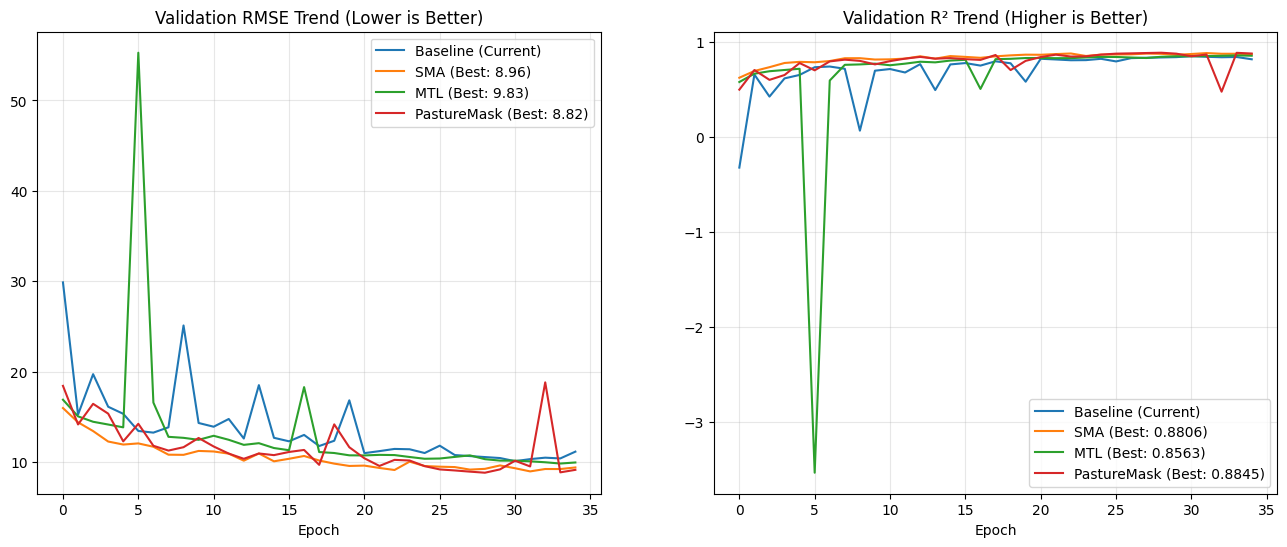


=== 2. 模型複雜度分析 ===


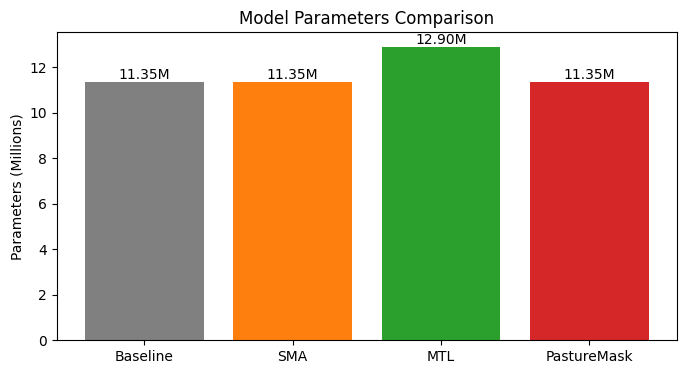


=== 3. 深度可視化 (Sample Analysis) ===
Target Biomass: 7.72


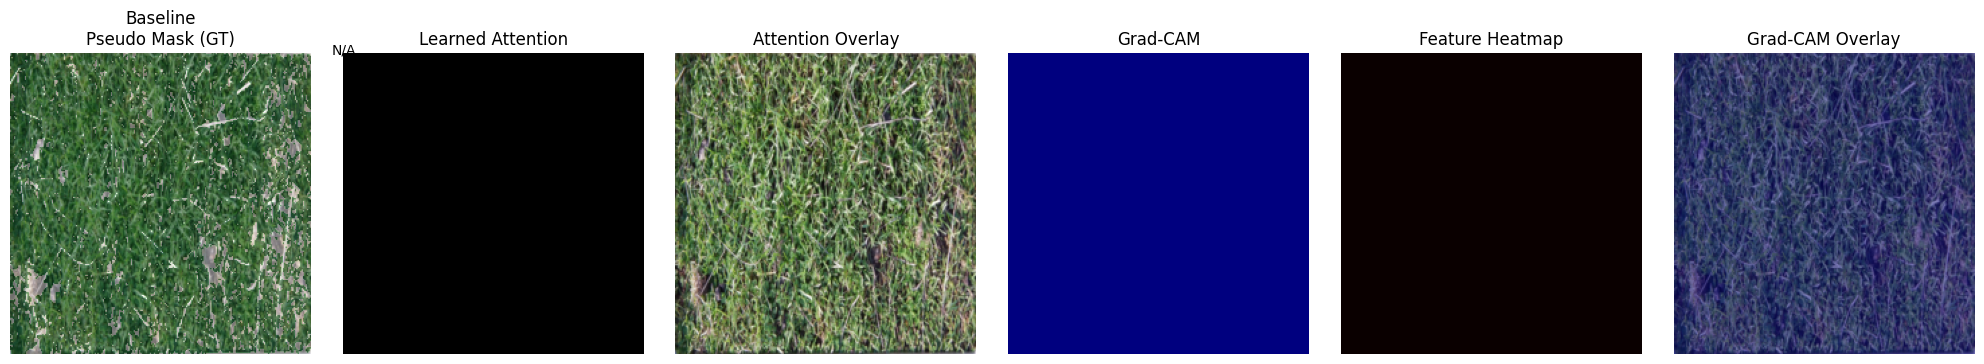

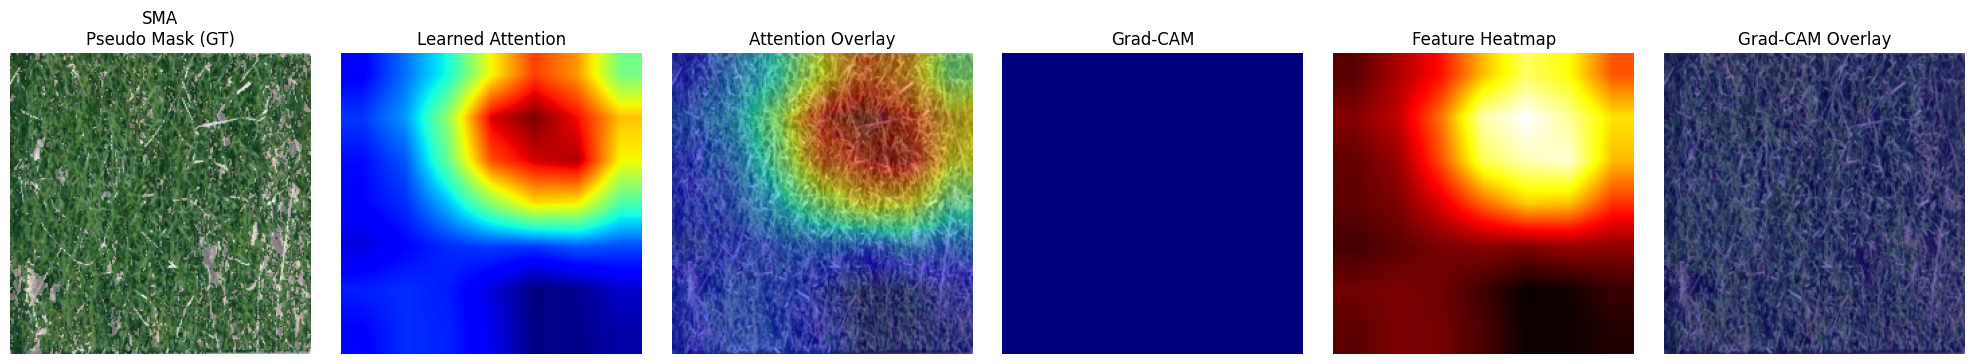

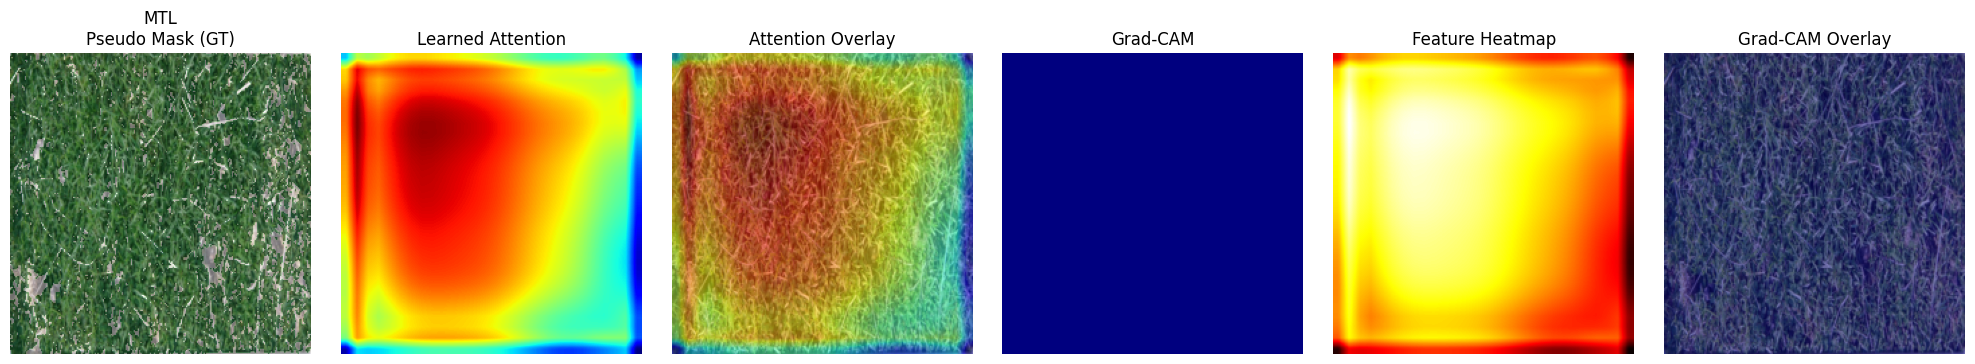

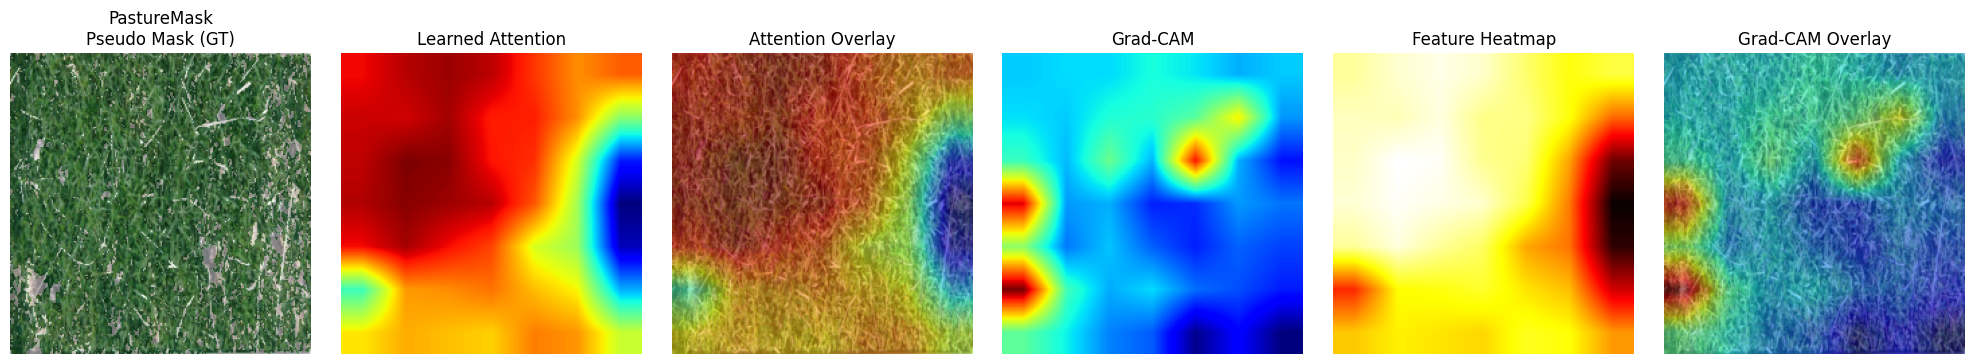

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np 
import cv2
from torch.utils.data import DataLoader

# ==========================================
# 工具函式：計算參數量
# ==========================================
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ==========================================
# 工具函式：Grad-CAM
# ==========================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.handle1 = self.target_layer.register_forward_hook(self.save_activation)
        self.handle2 = self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def remove_hooks(self):
        self.handle1.remove()
        self.handle2.remove()

    def __call__(self, inputs):
        self.model.zero_grad()
        
        # Forward pass
        output = self.model(*inputs)
        
        # 處理輸出 (取 regression score)
        if isinstance(output, tuple):
            score = output[0]
        else:
            score = output
            
        # Backward pass
        score.sum().backward()
        
        # Generate CAM
        grads = self.gradients
        acts = self.activations
        
        if grads is None or acts is None:
            return np.zeros((224, 224))

        weights = grads.mean(dim=(2, 3), keepdim=True)
        cam = (weights * acts).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
        return cam.detach().cpu().numpy()[0, 0]

# ==========================================
# 1. 載入訓練歷史並繪圖 (RMSE & R2)
# ==========================================
print("\n=== 1. 訓練趨勢分析 ===")
model_configs = [
    # (顯示名稱, 模型類別, 權重檔名, 歷史檔名)
    ("Baseline", ResNet18_Fusion, "best_resnet18_baseline.pth", "history_Baseline.npy"), # 假設基線歷史檔名
    ("SMA", SMA_Fusion, "best_SMA.pth", "history_SMA.npy"),
    ("MTL", MTL_Fusion, "best_MTL.pth", "history_MTL.npy"),
    ("PastureMask", PastureMask_Fusion, "best_PastureMask.pth", "history_PastureMask.npy")
]

# 嘗試收集歷史數據
plt.figure(figsize=(16, 6))

# RMSE Plot
plt.subplot(1, 2, 1)
for name, _, _, hist_file in model_configs:
    try:
        # 嘗試讀取 npy
        hist = np.load(hist_file, allow_pickle=True).item()
        rmse_curve = hist.get('val_rmse', [])
        if rmse_curve:
            plt.plot(rmse_curve, label=f"{name} (Best: {min(rmse_curve):.2f})")
    except:
        # 如果讀不到檔，嘗試從記憶體變數讀 (僅限當前 Session 有跑過)
        if name == "Baseline" and 'val_rmses' in globals():
            plt.plot(val_rmses, label=f"Baseline (Current)")
        else:
            print(f"⚠️ 無法讀取 {name} 的歷史紀錄 ({hist_file})")

plt.title("Validation RMSE Trend (Lower is Better)")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True, alpha=0.3)

# R2 Plot
plt.subplot(1, 2, 2)
for name, _, _, hist_file in model_configs:
    try:
        hist = np.load(hist_file, allow_pickle=True).item()
        r2_curve = hist.get('val_r2', [])
        if r2_curve:
            plt.plot(r2_curve, label=f"{name} (Best: {max(r2_curve):.4f})")
    except:
        if name == "Baseline" and 'val_r2s' in globals():
            plt.plot(val_r2s, label=f"Baseline (Current)")

plt.title("Validation R² Trend (Higher is Better)")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# 2. 參數量分析
# ==========================================
print("\n=== 2. 模型複雜度分析 ===")
param_counts = {}
for name, cls, _, _ in model_configs:
    dummy_model = cls(len(num_cols), n_states, n_species, n_targets)
    param_counts[name] = count_parameters(dummy_model) / 1e6

plt.figure(figsize=(8, 4))
bars = plt.bar(param_counts.keys(), param_counts.values(), color=['gray', '#ff7f0e', '#2ca02c', '#d62728'])
plt.ylabel("Parameters (Millions)")
plt.title("Model Parameters Comparison")
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{bar.get_height():.2f}M", ha='center', va='bottom')
plt.show()

# ==========================================
# 3. 深度可視化 (Grad-CAM & Attention)
# ==========================================
print("\n=== 3. 深度可視化 (Sample Analysis) ===")

# 準備樣本
model_eval_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
sample_batch = next(iter(model_eval_loader))
imgs, nums, states, species, t_ids, _, raw_targets, mask_gt = sample_batch
imgs, nums, states, species, t_ids = imgs.to(device), nums.to(device), states.to(device), species.to(device), t_ids.to(device)
mask_gt_np = mask_gt[0, 0].cpu().numpy()

# 顯示用原圖
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
orig_img_disp = (imgs[0] * std + mean).permute(1, 2, 0).cpu().numpy()
orig_img_disp = np.clip(orig_img_disp, 0, 1)

print(f"Target Biomass: {raw_targets.item():.2f}")

# 對每個模型進行分析
for name, cls, weight_path, _ in model_configs:
    # 1. 初始化並載入權重
    model = cls(len(num_cols), n_states, n_species, n_targets).to(device)
    try:
        model.load_state_dict(torch.load(weight_path))
        # print(f"已載入 {name} 權重")
    except Exception as e:
        print(f"⚠️ {name} 權重載入失敗，將使用隨機初始權重。錯誤: {e}")

    model.eval()
    
    # 2. 獲取 Learned Mask (如有)
    learned_mask = np.zeros((224, 224))
    inputs = (imgs, nums, states, species, t_ids)
    
    with torch.no_grad():
        out = model(*inputs)
        if isinstance(out, tuple) and len(out) > 1:
            raw_mask = out[1] # 可能是 attention map 或 decoded mask
            
            # 維度處理 
            if raw_mask.dim() == 4: # [B, C, H, W]
                pass
            elif raw_mask.dim() == 3: # [B, H, W] -> [B, 1, H, W]
                raw_mask = raw_mask.unsqueeze(1)
            
            # 插值到 224x224
            if raw_mask.shape[-1] != 224:
                resized_mask = F.interpolate(raw_mask, size=(224, 224), mode='bilinear', align_corners=False)
            else:
                resized_mask = raw_mask
                
            learned_mask = resized_mask[0, 0].cpu().numpy()

    # 3. 計算 Grad-CAM
    # 自動判斷 Target Layer
    target_layer = None
    if name == "Baseline":
        # 基線: model.cnn.layer4[-1]
        target_layer = model.cnn.layer4[-1]
    else:
        target_layer = model.features[-1]
    
    cam_map = np.zeros((224, 224))
    if target_layer is not None:
        gcam = GradCAM(model, target_layer)
        cam_map = gcam(inputs)
        gcam.remove_hooks()
        
    # 4. 繪圖
    plt.figure(figsize=(20, 3.5))
    
    # (A) GT Mask
    plt.subplot(1, 6, 1)
    plt.imshow(orig_img_disp)
    plt.imshow(mask_gt_np, cmap='Greens', alpha=0.4)
    plt.title(f"{name}\nPseudo Mask (GT)")
    plt.axis('off')
    
    # (B) Learned Attention
    plt.subplot(1, 6, 2)
    if name == "Baseline":
        plt.text(0.5, 0.5, "N/A", ha='center')
        plt.imshow(np.zeros_like(learned_mask), cmap='gray')
    else:
        plt.imshow(learned_mask, cmap='jet')
    plt.title("Learned Attention")
    plt.axis('off')
    
    # (C) Soft-mask Overlay
    plt.subplot(1, 6, 3)
    plt.imshow(orig_img_disp)
    if name != "Baseline" and learned_mask.max() > 0:
        plt.imshow(learned_mask, cmap='jet', alpha=0.5)
    plt.title("Attention Overlay")
    plt.axis('off')
    
    # (D) Grad-CAM
    plt.subplot(1, 6, 4)
    plt.imshow(cam_map, cmap='jet')
    plt.title("Grad-CAM")
    plt.axis('off')

    # (E) Feature Focus (Heatmap)
    plt.subplot(1, 6, 5)
    focus = learned_mask if name != "Baseline" else cam_map
    plt.imshow(focus, cmap='hot')
    plt.title("Feature Heatmap")
    plt.axis('off')

    # (F) Final Overlay
    plt.subplot(1, 6, 6)
    plt.imshow(orig_img_disp)
    plt.imshow(cam_map, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM Overlay")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()